# Frequency component of swim bouts for tuning curve generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math

import scipy.stats
from scipy import signal

from clam import bouts
from clam.utils import peakdet
from clam.utils import filter_peaks_by_spacing

%matplotlib inline

In [2]:
def tail_beat_count(bout_start, bout_end, peak_locs, trough_locs):
    
    nbeats = []
    for i in range(len(bout_start)):
        
        startloc_r = np.argwhere(peak_locs > boutstart[i])[0]
        endloc_r = np.argwhere(peak_locs > boutend[i])[0]
        
        startloc_l = np.argwhere(trough_locs > boutstart[i])[0]
        endloc_l = np.argwhere(trough_locs > boutend[i])[0]        
        
        count_r = endloc_r - startloc_r
        count_l = endloc_l - startloc_l
        
        nbeats.append( (count_r[0] + count_l[0]) / 2 )
        
    
    return nbeats

## Load tail tracking data

In [3]:
load = np.load('trackdata.npz')

endPoints = load['endPoints']

framerate = 300


savedata = True
saveas = 'boutkinematics.npz'

## Distance map of endpoint of the tail from rest position

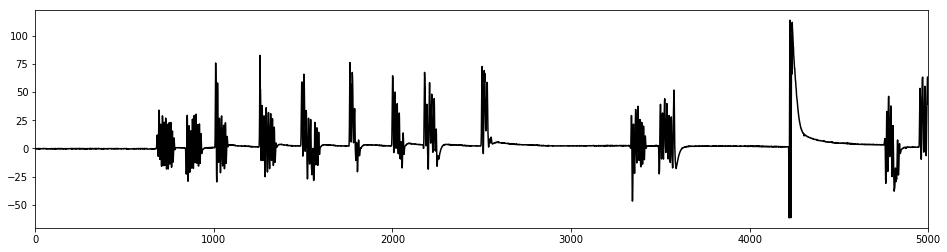

In [4]:
endRest = [np.median(endPoints[0]), np.median(endPoints[1])]

distances = []
d = 0
for i in range(len(endPoints[0])-1):
    d +=  (endPoints[0][i+1] - endPoints[0][i+1]) + (endPoints[1][i+1] - endPoints[1][i])

    distances.append(d)

plt.figure(figsize=[16,4])

plt.plot(distances, color='black')
plt.xlim(0,len(distances))

rectified = [abs(x) for x in distances]

## Detect inflection points that represent the peak tail beat amplitude during each swing

In [5]:
minspacing = 20 #milliseconds
framespacing = int(minspacing*framerate/1000)

#TODO load actual timestamp
timaxis = np.arange(0,len(distances)*1/framerate,1/framerate)

peaks,troughs = peakdet(distances, 10)

filtered_peaks = filter_peaks_by_spacing(peaks,framespacing)
filtered_troughs = filter_peaks_by_spacing(troughs,framespacing)

#plt.figure(figsize=[14,6])
#plt.plot(distances,color='black')
#plt.scatter(filtered_peaks[:,0],filtered_peaks[:,1],s=50,color='red')
#plt.scatter(filtered_troughs[:,0],filtered_troughs[:,1],s=50,color='blue')

locs = np.zeros(len(distances))
locs[filtered_peaks[:,0].astype(int)] = 1

## Calculate tail beat frequency for each swing of the tail within a bout

In [6]:
boutstart,boutend = bouts.bout_detect(rectified,5,20,7)

beat_count = tail_beat_count(boutstart, boutend, filtered_peaks[:,0], filtered_troughs[:,0])

duration = bouts.bout_duration([boutstart,boutend], timaxis)

tbf = [x/y for x,y in zip(beat_count,duration)]

peaktimes = [timaxis[int(x)] for x in filtered_peaks[:,0]]
peakdiffs = list(abs(np.diff(peaktimes)))
peakdiffs.append(0)


itbf = [0]*len(timaxis)

for (index,replacement) in zip(filtered_peaks[:,0], peakdiffs):
    itbf[int(index)] = replacement
    
for i in range(len(boutstart)):
    endloc = int(filtered_peaks[:,0][np.where(np.array(filtered_peaks[:,0]) < boutend[i])[0][-1]])
    itbf[endloc] = 0

for i in range(len(itbf)):
    if itbf[i] > 0:
        itbf[i] = 1/itbf[i]
        

## Transform binned tail beat frequencies to a continuous density function

Text(0.5,0,'Frequency(Hz)')

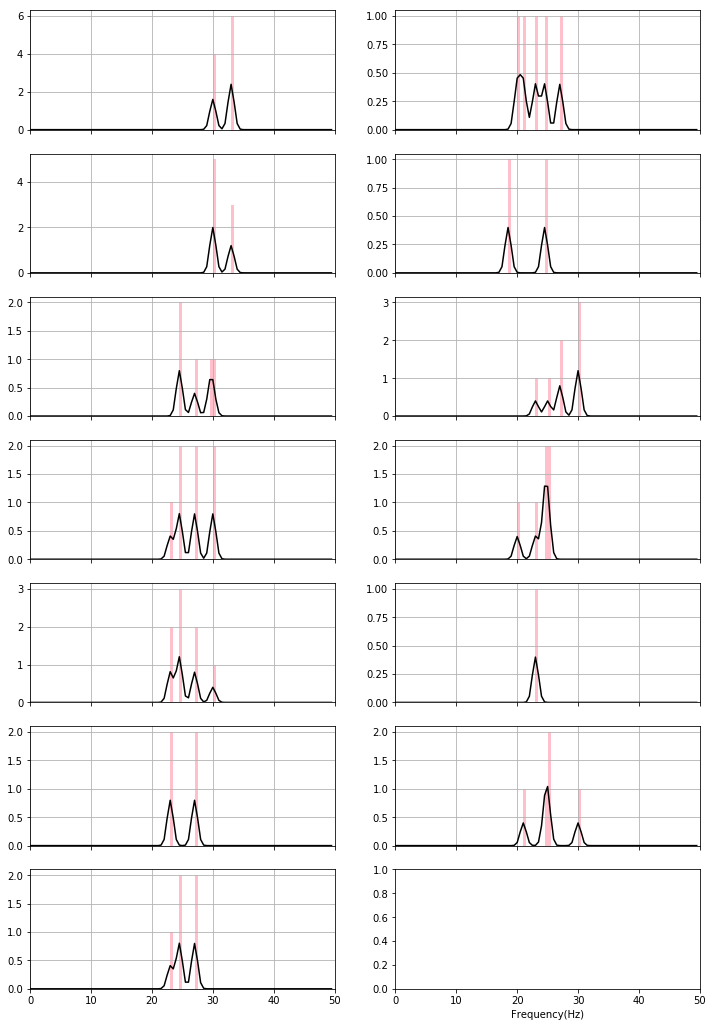

In [7]:
nbouts = len(boutstart)
max_freq = 50
sigma = 0.5

binwidth = 0.5
kernel_binwidth = 0.5

kernel_edges = np.arange(-3*sigma,3*sigma+1,kernel_binwidth)
kernel = scipy.stats.norm.pdf(kernel_edges,loc=0,scale=sigma)*kernel_binwidth

normalize = False

plot = True

freq_axis = np.arange(0,max_freq,binwidth)

if plot:
    columns = 2
    plotlim = (0,max_freq)
    fig, axarr = plt.subplots(math.ceil(nbouts/columns),columns, figsize=[12,18], sharex = True)

bout_freqs = []
binned_freqs = []
cont_freqs = []

for i in range(len(boutstart)):
    
    freqs = itbf[boutstart[i]:boutend[i]]
    freqs = [x for x in freqs if x >0]
    bout_freqs.append(freqs)
    
    hist = np.histogram(freqs,range = [0,max_freq], bins = math.ceil(max_freq/binwidth), density=normalize)
    
    if normalize:
        binned_freqs.append(list(hist[0]*binwidth))
        s = scipy.signal.convolve(hist[0],kernel,'same')*binwidth
    else:
        binned_freqs.append(list(hist[0]))
        s = scipy.signal.convolve(hist[0],kernel,'same')
        
    cont_freqs.append(s)

    if plot:
        plot_hist = axarr[i%math.ceil(nbouts/columns),
                     math.floor(i/(nbouts/columns))].hist(freqs,
                     range = [0,max_freq], bins = math.ceil(max_freq/binwidth), color = 'pink',
                                                            density=normalize)
        
        axarr[i%math.ceil(nbouts/columns),math.floor(i/(nbouts/columns))].plot(freq_axis,s, color='black')
        axarr[i%math.ceil(nbouts/columns),math.floor(i/(nbouts/columns))].set_xlim(0,max_freq)

        axarr[i%math.ceil(nbouts/columns),math.floor(i/(nbouts/columns))].grid()
        
plt.xlabel('Frequency(Hz)')

## Get frequency components for each bout

In [8]:
bout_order = []
freq_comp_sorted = []

for f in range(len(freq_axis)):
    
    f_comp = []
    for b in range(nbouts):
        f_comp.append(cont_freqs[b][f])
    
    b_order = [x for _,x in sorted(zip(f_comp,np.arange(0,nbouts,1)))]
    f_sorted = sorted(f_comp)
    
    bout_order.append(b_order)
    freq_comp_sorted.append(f_sorted)

## Save results

In [9]:
if savedata:
    np.savez(saveas, bout_frequency_composition = cont_freqs, freq_axis = freq_axis, 
             bout_order = bout_order, freq_comp_sorted = freq_comp_sorted)